In [1]:
import xport
import numpy as np
import pandas as pd
import os
import collections

import networkx as nx

#https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
# pd.set_option('display.float_format', lambda x: '%.4f' % x)

import textwrap

"""
Connect Pltly to Jupyter notebook
"""

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl
init_notebook_mode(connected=True)

from plotly.subplots import make_subplots
import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.serif'] = "serif"
matplotlib.rcParams['font.family'] = "Times New Roman"

import seaborn as sns

import plotly
import plotly.io as pio

import pickle

# 

# from dynamicTreeCut import cutreeHybrid
# from scipy.spatial.distance import pdist
# from sklearn.cluster import AgglomerativeClustering
# import scipy.cluster.hierarchy as sch

# silence NumbaPerformanceWarning
# import warnings
# from numba.errors import NumbaPerformanceWarning
# warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

"""
Autoreload base modules
"""

%load_ext autoreload
%autoreload 1

%aimport FNDDS_base
# %aimport TargetData
# %aimport WholeFoodsData
%aimport foodome_base
# %aimport food_api

# %aimport OpenFoodFacts.OpenFoodFactsAnalyze

"""
Reset a library to default settings
"""
# import importlib
# importlib.reload(mpl); 
# importlib.reload(plt)
# importlib.reload(sns)

'\nReset a library to default settings\n'

# Load Data

In [2]:
datasets_path = {
    "FoodData_Central 2020-03-31": "input_data/FoodData_Central_2020-03-31.accdb"
}

FDC20 = foodome_base.load_access_tables(dataset_path=datasets_path["FoodData_Central 2020-03-31"],
                               tables=[
                                   "nutrient",
                                   "food_nutrient", "nutrient", "food", "branded_food"
                                   ,"food_category", "food_attribute",
                                   "survey_fndds_food", "wweia_food_category"
                                  ])

FDC20["food_category"]["id"] = FDC20["food_category"]["id"].astype(float)
FDC20["food"]["food_category_id"] = FDC20["food"]["food_category_id"].astype(float)

FDC20["food"] = pd.merge(
    FDC20["food"], 
    FDC20["food_category"].rename(columns={"code": "FDC_category_code", "description": "FDC_category_description"}), 
    left_on=["food_category_id"], right_on=["id"], how="left")

FDC20["survey_fndds_food"] = pd.merge(
    FDC20["survey_fndds_food"], 
    FDC20["wweia_food_category"],#.rename(columns={"code": "FDC_category_code", "description": "FDC_category_description"}), 
    left_on="wweia_category_code", right_on="wweia_food_category_code").drop(columns=["wweia_category_code"])

Loaded from pickle: nutrient
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: nutrient | Number of rows: 235
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: food_nutrient | Number of rows: 5370480
Loaded from pickle: nutrient
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: nutrient | Number of rows: 235
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: food | Number of rows: 335142
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: branded_food | Number of rows: 299462
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: food_category | Number of rows: 28
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: food_attribute | Number of rows: 153975
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: survey_fndds_food | Number of rows: 8690
Loaded input_data/FoodData_Central_2020-03-31.accdb --> Table: wweia_food_category | Number of rows: 155


In [3]:
q = pd.read_csv("input_data/all_food_datasets_nuts_num.csv")

q[q["count_nutrients"] == 0]
print(q['dataset'].unique())
q.columns

q[(q["dataset"] == "WholeFoods") & (q["count_nutrients"] > 0)].describe()

C:\anaconda3\envs\foodome\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



['SR Legacy' 'FNDDS' 'USDA Branded' 'Open Food Facts' 'Target'
 'WholeFoods' 'Walmart']


,Unnamed: 0,count_nutrients
count,12317.000000,12317.000000
mean,6860.818625,15.979865
std,3997.068573,6.394502
min,0.000000,1.000000
25%,3490.000000,15.000000
50%,6812.000000,15.000000
75%,10176.000000,16.000000
max,14409.000000,35.000000


In [4]:
q[q['dataset'] == 'FNDDS']

,Unnamed: 0,id,count_nutrients,category_name,dataset
7793,0,781082,65.0,Human milk,FNDDS
7794,1,781083,65.0,"Milk, reduced fat",FNDDS
7795,2,781084,65.0,"Milk, whole",FNDDS
7796,3,781085,65.0,"Milk, whole",FNDDS
7797,4,781086,65.0,"Milk, whole",FNDDS
...,...,...,...,...,...
16478,8685,789767,65.0,Not included in a food category,FNDDS
16479,8686,789768,65.0,Not included in a food category,FNDDS
16480,8687,789769,65.0,Not included in a food category,FNDDS
16481,8688,789770,65.0,Not included in a food category,FNDDS


# Create Distribution of Number of Nutrients

In [6]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

def plot_nuts(dist_data_dict, remove_kde_fit_line=False):
    fig, axes = plt.subplots(len(dist_data_dict), 2, figsize=(14, 2.5 * len(dist_data_dict)))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)
       
    if len(dist_data_dict) == 1:
        axes = np.array([[axes[0], axes[1]]])
        pass
    
    i = 0
    
    for name, data_dict in dist_data_dict.items():
        num_records = len(data_dict["dist_array"])
        title = "{} - {:,} Products".format(name, num_records)
        
        x = sns.distplot(data_dict["dist_array"], kde=False, rug=False, ax = axes[i, 0])
        x.set_yscale('log')
        # x.set_xscale('log')
        axes[i, 0].set_title(title + " (y-axis log scale)", pad=None)
#         axes[i, 0].xaxis.set_major_locator(MultipleLocator(5))

        x = sns.distplot(data_dict["dist_array"], kde=True, rug=False, ax = axes[i, 1])
        axes[i, 1].set_title("PDF - " + title, pad=None)
        if remove_kde_fit_line:
            x.get_lines()[0].remove()
            pass
#         axes[i, 0].xaxis.set_major_locator(MultipleLocator(5))
#         axes[i, 0].xaxis.set_minor_locator(MultipleLocator(1))

        i += 1
        pass
    pass

# Median Num Nuts for Branded Products

In [9]:
food_df = FDC20["food"]

food_nuts_df = pd.merge(
        food_df,
        FDC20["food_nutrient"][["fdc_id", "nutrient_id", "amount"]], 
        on="fdc_id", how="left"
    )

energy_nuts_ids = {
            'Energy KCAL': 1008, # 'Energy 1008' unit: KCAL
            # in FNDDS is called 'Energy' with nut id 1008
            'Energy kJ': 1062, # 'Energy 1062' unit: kJ (this id is NOT used in FNDDS)
#             'Folate, DFE': 1190, # 'Folate, DFE 1190',
#             'Vitamin A, RAE': 1106 # 'Vitamin A, RAE 1106'
        }
        
food_nuts_df = food_nuts_df[~food_nuts_df["nutrient_id"].isin(energy_nuts_ids.values())]

branded_df = food_nuts_df[food_nuts_df['data_type'] == 'branded_food']
# # FDC20['branded_food']
# len(branded_df)
branded_nut_count = branded_df.groupby('fdc_id').agg(count_nutrients = ('fdc_id', np.size)).reset_index()

In [10]:
print('Median num nuts (filtered calories): ', branded_nut_count['count_nutrients'].median())
branded_nut_count['count_nutrients'].describe()

Median num nuts (filtered calories):  13.0


count    299443.000000
mean     12.602869    
std      3.962854     
min      1.000000     
25%      12.000000    
50%      13.000000    
75%      14.000000    
max      47.000000    
Name: count_nutrients, dtype: float64

In [11]:
print(len(branded_nut_count))
branded_nut_count.value_counts() / len(branded_nut_count)

299443


fdc_id  count_nutrients
344646  31                 0.000003
589624  13                 0.000003
589645  13                 0.000003
589644  14                 0.000003
589643  20                 0.000003
                             ...   
469749  13                 0.000003
469748  13                 0.000003
469747  13                 0.000003
469744  22                 0.000003
808659  4                  0.000003
Length: 299443, dtype: float64

In [14]:
FDC20['nutrient'][FDC20['nutrient']['name'].str.contains('Sugars', case=False)]
# FDC20['nutrient']
# FDC20['nutrient'][FDC20['nutrient']['nutrient_nbr'].astype(float).isin(nut_12p.values())]

,id,name,unit_name,nutrient_nbr,rank
24,1063,"Sugars, Total NLEA",G,269.3,1500.0
131,1235,"Sugars, added",G,539,1540.0
208,2000,"Sugars, total including NLEA",G,269,1510.0


In [15]:
FDC20['nutrient'][FDC20['nutrient']['name'].str.contains('vitamin', case=False)]
FDC20['nutrient']['nutrient_nbr']

0      202  
1      203  
2      204  
3      205  
4      207  
5      208  
6      209  
7      210  
8      211  
9      212  
10     213  
11     214  
12     221  
13     227  
14     230  
15     236  
16     242  
17     243  
18     205.2
19     255  
20     261  
21     262  
22     263  
23     268  
24     269.3
25     284  
26     287  
27     290  
28     291  
29     294  
30     295  
31     297  
32     298  
33     299  
34     301  
35     302  
36     303  
37     304  
38     305  
39     306  
40     307  
41     308  
42     309  
43     310  
44     311  
45     312  
46     313  
47     314  
48     315  
49     316  
50     317  
51     318  
52     319  
53     320  
54     321  
55     322  
56     323  
57     324  
58     325  
59     326  
60     327  
61     328  
62     330  
63     331  
64     338.2
65     334  
66     338.1
67     337  
68     338  
69     340  
70     341  
71     342  
72     343  
73     344  
74     345  
75     346  
76     347  

In [16]:
# "12P": [
#         'protein', 'totalFat', 'carbohydrates', 'sugar', 'fiber', 'calcium', 'iron',
#         'sodium', 'vitaminC', 'cholesterol', 'saturatedFat', 'vitaminA'
#     ]
    
nut_12p = {
    'Protein': 203, 'Total Fat':204,'Carbohydrate': 205, 
    'Sugars, total': 269, 'Fiber, total dietary': 291, 
    'Calcium': 301, 'Iron': 303, 'Sodium': 307,'Vitamin C': 401, 
    'Cholesterol': 601, 'Fatty acids, total saturated': 606, 
    'Vitamin A, IU': 318, 'Vitamin A, RAE': 320
}

# All Other

List of sources in food data central

In [17]:
FDC20["food"].groupby("data_type").agg({"description": np.size})

,description
data_type,
agricultural_acquisition,810
branded_food,299462
foundation_food,116
market_acquisition,5229
sample_food,1731
sr_legacy_food,7793
sub_sample_food,11311
survey_fndds_food,8690


In [20]:
VitaminA=['Retinol', 'Carotene, beta', 'Carotene, alpha', 'Cryptoxanthin, beta']
CaloryDecomp=['Protein','Total Fat','Carbohydrate']

# FDC20['nutrient']
NutDesc = pd.read_excel('input_data/NutDesc.xlsx')
all_nuts = list(NutDesc['Nutrient description'])
print("AllNuts [{}]: {}".format(len(all_nuts), all_nuts))


# RFFNDDSpredS = pd.read_csv('data/RFFNDDSpredS_cleaned.csv')
RFFNDDSpredS = pd.read_csv('input_data/FNDDS_2009-10_Training_Data.csv')

RFFNDDSpredS = RFFNDDSpredS.loc[:, 'Protein': 'Fatty acids, total polyunsaturated']
g_nuts = list(RFFNDDSpredS.columns)

print("\nG Nuts [{}]: {}".format(len(g_nuts), g_nuts))

set(all_nuts) - set(g_nuts)

AllNuts [65]: ['Protein', 'Total Fat', 'Carbohydrate', 'Energy', 'Alcohol', 'Water', 'Caffeine', 'Theobromine', 'Sugars, total', 'Fiber, total dietary', 'Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium', 'Sodium', 'Zinc', 'Copper', 'Selenium', 'Retinol', 'Vitamin A, RAE', 'Carotene, beta', 'Carotene, alpha', 'Vitamin E (alpha-tocopherol)', 'Vitamin D (D2 + D3)', 'Cryptoxanthin, beta', 'Lycopene', 'Lutein + zeaxanthin', 'Vitamin C', 'Thiamin', 'Riboflavin', 'Niacin', 'Vitamin B-6', 'Folate, total', 'Vitamin B-12', 'Choline, total', 'Vitamin K (phylloquinone)', 'Folic acid', 'Folate, food', 'Folate, DFE', 'Vitamin E, added', 'Vitamin B-12, added', 'Cholesterol', 'Fatty acids, total saturated', '4:0', '6:0', '8:0', '10:0', '12:0', '14:0', '16:0', '18:0', '18:1', '18:2', '18:3', '20:4', '22:6 n-3', '16:1', '18:4', '20:1', '20:5 n-3', '22:1', '22:5 n-3', 'Fatty acids, total monounsaturated', 'Fatty acids, total polyunsaturated']

G Nuts [62]: ['Protein', 'Total Fat', 'Carbohydrate',

{'10:0',
 '12:0',
 '14:0',
 '16:0',
 '16:1',
 '18:0',
 '18:1',
 '18:2',
 '18:3',
 '18:4',
 '20:1',
 '20:4',
 '22:1',
 '4:0',
 '6:0',
 '8:0',
 'Energy',
 'Folate, DFE',
 'Vitamin A, RAE'}

In [21]:
def food_table_nuts_count_dis(dataset_name, debug=False, remove_energy_nutrients_or_nuts_with_equivalents=False):
#     if dataset_name == "branded_food":
#         raise Exception("For branded_food use its special table FDC20['branded_food'] to get categories!")
    
    food_df = FDC20["food"][FDC20["food"]["data_type"] == dataset_name]
    
    food_nuts_df = pd.merge(
        food_df[["fdc_id"]],
        FDC20["food_nutrient"][["fdc_id", "nutrient_id", "amount"]], 
        on="fdc_id", how="left"
    )
    
    if debug: # was using this find nutrients ids that needs to be removed
        food_nuts_df = pd.merge(food_nuts_df, FDC20["nutrient"][["id", "name"]], left_on="nutrient_id", right_on="id").drop(columns=["id"])
        food_nuts_df["name"] = food_nuts_df["name"] + " " + food_nuts_df["nutrient_id"].astype(str)
    
#     remove energy nutrients or equivalents 
    if False and remove_energy_nutrients_or_nuts_with_equivalents and dataset_name in ["survey_fndds_food", "sr_legacy_food"]:
        remove_nuts_FoodDataCentral_ids = {
            'Energy KCAL': 1008, # 'Energy 1008' unit: KCAL
            # in FNDDS is called 'Energy' with nut id 1008
            'Energy kJ': 1062, # 'Energy 1062' unit: kJ (this id is NOT used in FNDDS)
            'Folate, DFE': 1190, # 'Folate, DFE 1190',
            'Vitamin A, RAE': 1106 # 'Vitamin A, RAE 1106'
        }
        
        food_nuts_df = food_nuts_df[~food_nuts_df["nutrient_id"].isin(remove_nuts_FoodDataCentral_ids.values())]
        
        pass
    
#     return food_nuts_df
    food_nuts_df_non_zero_nuts = (
        food_nuts_df[~pd.isnull(food_nuts_df).any(axis=1)]
        .groupby("fdc_id")
        .agg({"nutrient_id": np.size})
        .rename(columns={"nutrient_id": "count_nutrients"})
    )
    
    food_nuts_items_with_zero_nuts_df = food_nuts_df[food_nuts_df["amount"].isnull()].drop(columns=["nutrient_id", "amount"])
    food_nuts_items_with_zero_nuts_df["count_nutrients"] = 0
    
    food_nuts_all_df = pd.concat([
        food_nuts_df_non_zero_nuts.reset_index(), 
        food_nuts_items_with_zero_nuts_df.reset_index()
    ])
    
    if dataset_name == "survey_fndds_food":
        category_df=FDC20["survey_fndds_food"]
        category_column = "wweia_food_category_description"
        
    elif dataset_name == "branded_food":
        category_df = FDC20["branded_food"]
        category_column = "branded_food_category"
        
    else:
        category_df=FDC20["food"]
        category_column = "FDC_category_description"
    
    print("Warning: only for two datasets ['survey_fndds_food', 'branded_food'] targeted tables are used for retrieving categories. For the remaining datasets FDC20['food'][['FDC_category_description']] is used!")
    
    food_nuts_all_df = pd.merge(
        food_nuts_all_df,
        category_df[["fdc_id", category_column]],
        on="fdc_id", how="left").rename(columns={
            category_column: "category_name",
            "fdc_id": "id"
    }).drop(columns="index")
    
#     if dataset_name in ["survey_fndds_food"]:
#         remove_nuts_FNDDS_ids = {
#             'Energy': 208,
#             'Folate, DFE': 435,
#             'Vitamin A, RAE': 320
#         }

#         remove_nuts_FoodDataCentral_ids = {
#             'Energy': 1008, # 'Energy 1008' unit: KCAL
#             'Energy': 1062, # 'Energy 1062' unit: kJ (this id is NOT used in FNDDS)
#             'Folate, DFE': 1190, # 'Folate, DFE 1190',
#             'Vitamin A, RAE': 1106 # 'Vitamin A, RAE 1106'
#         }
#         v1 = ["Protein","Total Fat","Carbohydrate","Alcohol",
#       "@DEL Energy", "Water","Caffeine","Theobromine","Sugars, total","Fiber, total dietary","Calcium","Iron","Magnesium","Phosphorus","Potassium","Sodium","Zinc","Copper","Selenium","Retinol",
#       "@DEL Vitamin A, RAE",
#       "Carotene, beta","Carotene, alpha","Vitamin E (alpha-tocopherol)","Vitamin D (D2 + D3)","Cryptoxanthin, beta","Lycopene","Lutein + zeaxanthin","Vitamin C","Thiamin","Riboflavin","Niacin","Vitamin B-6","Folate, total","Vitamin B-12","Choline, total","Vitamin K (phylloquinone)","Folic acid","Folate, food",
#       "@DEL Folate, DFE",
#       "Vitamin E, added","Vitamin B-12, added","Cholesterol","Fatty acids, total saturated","4:00","6:00","8:00","10:00","12:00","14:00","16:00","18:00","18:01","18:02","18:03","20:04","22:6 n-3","16:01","18:04","20:01","20:5 n-3", "22:01", "22:5 n-3","Fatty acids, total monounsaturated","Fatty acids, total polyunsaturated"]
        
# #         Three nutrients are not directly used in giulia's classifier so lets ignore them ["@DEL Energy", "@DEL Vitamin A, RAE", "@DEL Folate, DFE"]
        
#         food_nuts_all_df["count_nutrients"] = food_nuts_all_df["count_nutrients"] - 3
#         pass
    
    return food_nuts_all_df

"""
 	description
data_type 	
agricultural_acquisition 	810
branded_food 	299462
foundation_food 	116
market_acquisition 	5229
sample_food 	1731
sr_legacy_food 	7793
sub_sample_food 	11311
survey_fndds_food 	8690
"""
# print(FNDDS_remove_nuts_FoodDataCentral_ids)
q = food_table_nuts_count_dis(dataset_name="survey_fndds_food", debug=False, remove_energy_nutrients_or_nuts_with_equivalents=False)
# len(q["name"].unique())
# q["count_nutrients"].unique()
q

,id,count_nutrients,category_name
0,781082,65,Human milk
1,781083,65,"Milk, reduced fat"
2,781084,65,"Milk, whole"
3,781085,65,"Milk, whole"
4,781086,65,"Milk, whole"
...,...,...,...
8685,789767,65,Not included in a food category
8686,789768,65,Not included in a food category
8687,789769,65,Not included in a food category
8688,789770,65,Not included in a food category


In [22]:
print(FDC20.keys())

food_df = FDC20['branded_food']

food_nuts_df = pd.merge(
        food_df[["fdc_id"]],
        FDC20["food_nutrient"][["fdc_id", "nutrient_id", "amount"]], 
        on="fdc_id", how="left"
    )

food_nuts_df = pd.merge(food_nuts_df, FDC20['nutrient'], left_on='nutrient_id', right_on='id')
food_nuts_df

food_nuts_df['name'].unique()

dict_keys(['nutrient', 'food_nutrient', 'food', 'branded_food', 'food_category', 'food_attribute', 'survey_fndds_food', 'wweia_food_category'])


array(['Calcium, Ca', 'Iron, Fe', 'Vitamin A, IU',
       'Vitamin C, total ascorbic acid', 'Cholesterol', 'Protein',
       'Total lipid (fat)', 'Carbohydrate, by difference', 'Energy',
       'Sugars, total including NLEA', 'Fiber, total dietary',
       'Sodium, Na', 'Fatty acids, total trans',
       'Fatty acids, total saturated',
       'Fatty acids, total monounsaturated',
       'Fatty acids, total polyunsaturated', 'Thiamin', 'Riboflavin',
       'Niacin', 'Folate, total', 'Potassium, K',
       'Vitamin D (D2 + D3), International Units', 'Folic acid',
       'Folate, DFE', 'Zinc, Zn', 'Vitamin B-6', 'Vitamin B-12',
       'Fiber, soluble', 'Magnesium, Mg', 'Phosphorus, P',
       'Vitamin E (label entry primarily)', 'Pantothenic acid',
       'Copper, Cu', 'Caffeine', 'Fiber, insoluble', 'Ash', 'Water',
       'Manganese, Mn', 'Vitamin K (phylloquinone)',
       'Vitamin D (D2 + D3)', 'Starch', 'Iodine, I', 'Molybdenum, Mo',
       'Chromium, Cr', 'Selenium, Se', 'Biotin', 'C

C:\anaconda3\envs\foodome\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



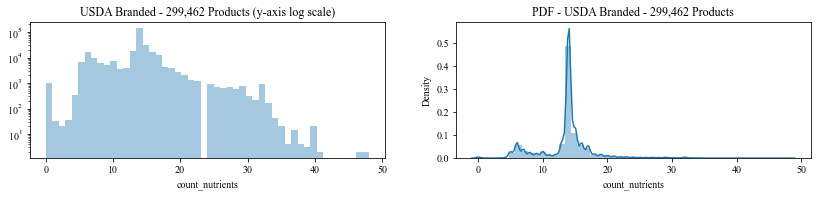

In [23]:
USDA_branded_products_num_nuts_df = food_table_nuts_count_dis(dataset_name="branded_food", remove_energy_nutrients_or_nuts_with_equivalents=False)

if False:
    USDA_branded_products_num_nuts_df.to_csv("data/USDA/USDA_Branded_food_num_nutrients_products_299462.csv")
    pass

plot_nuts({
    "USDA Branded": {"dist_array": USDA_branded_products_num_nuts_df["count_nutrients"]}
})

C:\anaconda3\envs\foodome\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\anaconda3\envs\foodome\lib\site-packages\seaborn\distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



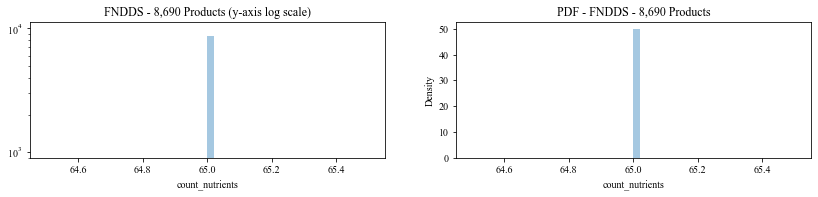

In [21]:
fndds_food_nuts_dist_df = food_table_nuts_count_dis("survey_fndds_food", remove_energy_nutrients_or_nuts_with_equivalents=False)

if False:
    sr_legacy_food_nuts_dist_df.to_csv("data/USDA/USDA_FNDDS_num_nutrients_products_8690.csv")

plot_nuts({
    "FNDDS": {"dist_array": fndds_food_nuts_dist_df["count_nutrients"]}
})

C:\anaconda3\envs\foodome\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



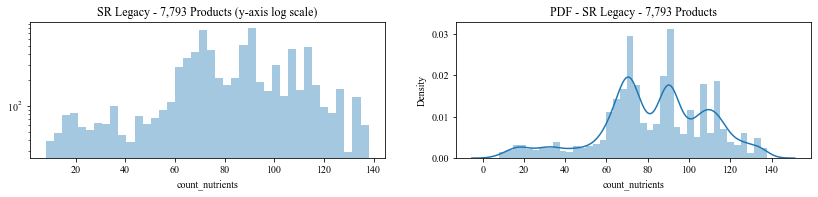

In [22]:
sr_legacy_food_nuts_dist_df = food_table_nuts_count_dis("sr_legacy_food", remove_energy_nutrients_or_nuts_with_equivalents=False)

if False:
    sr_legacy_food_nuts_dist_df.to_csv("data/USDA/USDA_sr_legacy_num_nutrients_products_7793.csv")
    
plot_nuts({
    "SR Legacy": {"dist_array": sr_legacy_food_nuts_dist_df["count_nutrients"]}
})